In [13]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(123)

In [21]:
# Load MNIST dataset as tensors using DataLoader class

batch_size = 128
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

def tensor_to_images(image_tensor, num_images=30, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=6)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [4]:
sample_img=next(iter(dataloader))
sample_img[0].shape
sample_img[-1][0:30]

tensor([0, 0, 9, 5, 3, 1, 1, 1, 4, 2, 0, 0, 7, 2, 3, 1, 5, 9, 7, 2, 6, 3, 5, 2,
        9, 9, 3, 6, 1, 3])

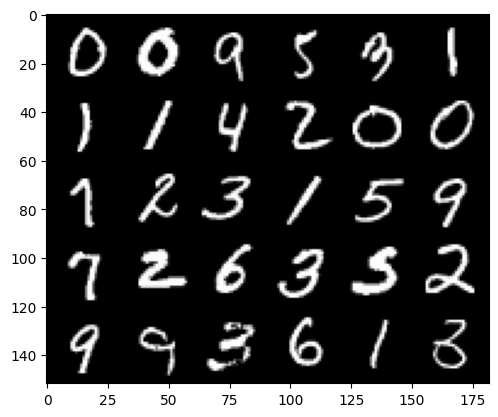

In [5]:
tensor_to_images(sample_img[0])

In [14]:
# Generator
class Generator(nn.Module):
    def __init__(self, noise_dimension=10,
                       image_dimension=784,
                       hidden_dimension=128):
        super(Generator, self).__init__()

        self.n_dim = noise_dimension
        self.im_dim = image_dimension
        self.h_dim = hidden_dimension

        # Generator network
        self.gen = nn.Sequential(
            self.generator_block(self.n_dim, self.h_dim),
            self.generator_block(self.h_dim, self.h_dim * 2),
            self.generator_block(self.h_dim * 2, self.h_dim * 4),
            self.generator_block(self.h_dim * 4, self.h_dim * 8),
            nn.Linear(self.h_dim * 8, self.im_dim),
            nn.Sigmoid()
        )

    def forward(self, noise):
        return self.gen(noise)

    # Simple neural network single block
    def generator_block(self, in_dimension, out_dimension):
        return nn.Sequential(
            nn.Linear(in_dimension, out_dimension),
            nn.BatchNorm1d(out_dimension),
            nn.ReLU(inplace=True),
        )

In [23]:
# Noise Function
def get_noise(n_samples, noise_vector_dimension, device='cpu'):
    return torch.randn(n_samples, noise_vector_dimension,device=device)

In [8]:
torch.rand(5,6, device = 'cpu')

tensor([[0.1841, 0.7264, 0.3153, 0.6871, 0.0756, 0.1966],
        [0.3164, 0.4017, 0.1186, 0.8274, 0.3821, 0.6605],
        [0.8536, 0.5932, 0.6367, 0.9826, 0.2745, 0.6584],
        [0.2775, 0.8573, 0.8993, 0.0390, 0.9268, 0.7388],
        [0.7179, 0.7058, 0.9156, 0.4340, 0.0772, 0.3565]])

In [20]:
# Descriminatior class
class Discriminator(nn.Module):
    def __init__(self,
                 image_dimension=784,
                 hidden_dimension=128):
        super(Discriminator, self).__init__()

        self.im_dim = image_dimension
        self.h_dim = hidden_dimension

        self.disc = nn.Sequential(
            self.discriminator_block(self.im_dim, self.h_dim * 4),
            self.discriminator_block(self.im_dim * 4, self.h_dim * 2),
            self.discriminator_block(self.im_dim * 2, self.h_dim),
            nn.Linear(self.h_dim, 1)
        )

    def forward(self, image):
        return self.disc(image)

    def discriminator_block(self, in_dimension, out_dimension):
      return nn.Sequential(
           nn.Linear(in_dimension, out_dimension),
           nn.LeakyReLU(0.2, inplace=True)
      )


In [10]:
# Hyperparameter of training loop
n_epochs = 200
noise_dimension = 64
lr = 0.00001
display_step = 500

criterion = nn.BCEWithLogitsLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [15]:
# Initiate model object
# Generator & Optimizer for Generator
gen = Generator(noise_dimension).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

# Discriminator & Optimizer for Discriminator
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [16]:
print(gen)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [17]:
# Loss Function
def get_disc_loss(gen, disc, criterion, real, num_images, noise_dimension, device):
    # Generate noise and pass to generator
    fake_noise = get_noise(num_images, noise_dimension, device=device)
    fake = gen(fake_noise)

    # Pass fake features to discriminator
    # All of them will got label as 0
    # .detach() here is to ensure that only discriminator parameters will get update
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred,
                               torch.zeros_like(disc_fake_pred))

    # Pass real features to discriminator
    # All of them will got label as 1
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred,
                               torch.ones_like(disc_real_pred))

    # Average of loss from both real and fake features
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, noise_dimension, device):
    # Generate noise and pass to generator
    fake_noise = get_noise(num_images, noise_dimension, device=device)
    fake = gen(fake_noise)

    # Pass fake features to discriminator
    # But all of them will got label as 1
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

In [24]:
# Training Loop
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        # Get number of batch size (number of image)
        # And get tensor for each image in batch
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)

        ### Traing discriminator ###
        # Zero out the gradient .zero_grad()
        # Calculate discriminator loss get_disc_loss()
        # Update gradient .gradient()
        # Update optimizer .step()
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, noise_dimension, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        ### Traing generator ###
        # Zero out the gradient .zero_grad()
        # Calculate discriminator loss get_gen_loss()
        # Update gradient .gradient()
        # Update optimizer .step()
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, noise_dimension, device)
        gen_loss.backward()
        gen_opt.step()

        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, noise_dimension, device=device)
            fake = gen(fake_noise)
            tensor_to_images(fake)
            tensor_to_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0

        cur_step += 1

  0%|          | 0/469 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x512 and 3136x256)